## Ex: extracting background from static camera's video using SVD

First, import the required libraries.

In [1]:
#numpy enables numeric calculations: we'll use it for SVD, vectors, matrices.
import numpy as np
#cv2 is opencv2 api (cv stands for computer vision)
import cv2

#this one will enable the plot function
import matplotlib.pyplot as plt

Second, set the right base dir and query details about the video. Check the output to make sure
the details make sense.

In [2]:
#set base dir
path='./'
#set filename
cap = cv2.VideoCapture(path+'shop.avi')

#use opencv2 API to query movie info
#movie width,height in pixels, length in frames and encoded format.
fw = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
fh = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
len = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
ccodec = int(cap.get(cv2.CAP_PROP_FOURCC))
print (fw,'x',fh, ',', len,' frames,',' codec=',ccodec, ', fps=', fps)

192 x 144 , 158  frames,  codec= 1145656920 , fps= 15


Now we'll read the video frame by frame: 
    -convert it to 8bpp instead of the current RGB 24bpp.
    -change shape of i'th frame to vector("flatten"), and copy into the i'th row of target matrix "mat".
    
    


In [3]:
#the matrix which i'th row will be the i'th frame, flatted to vector.
mat = np.zeros((len, fw*fh), dtype=np.uint8)

i = 0
while cap.isOpened():
    ret, frame = cap.read()
    if(ret == True):
        #show frame and wait 50ms 
        cv2.imshow('frame',frame)
        cv2.waitKey(50)
        
        #convert to gray and flatten the frame to vector
        gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        mat[i] = gray_image.ravel()
        
        #advance frame count
        i=i+1
    else:
        cap.release()
print('ok')

ok


Next, decompose "mat" using SVD to u,d,v, zeroise all but the first singular value and reconstruct the matrix u@d@v ('@' is the matrix multipliclation sign. '*' is the pointwise multiplication sign).

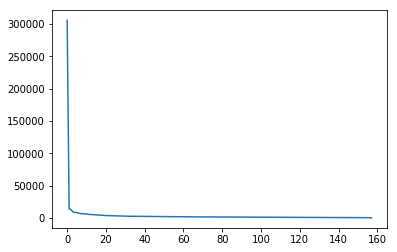

In [4]:
#call svd. Notive that the matrix size is huge, maybe there is a way to save memory. Go through SVD flags.
u,d,v = np.linalg.svd(mat, full_matrices=False)

#lets see what we got
plt.plot(d)
plt.show()

#clear sv's, reconstruct matrix...
d[1:] = 0
background_mat = (u * d) @ v

write the output to file.

In [5]:
#A format to write. Might need to change here, depends on available codecs.
writer = cv2.VideoWriter(path+'output.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, (fw, fh), False)
for i in range(background_mat.shape[0]):
    writer.write(background_mat[i].reshape(fh, fw).astype(np.uint8))

writer.release()
print('ok')

ok


read the output and show it on screen.

In [6]:
#show output
cap = cv2.VideoCapture(path+'output.avi')
while cap.isOpened():
    ret, frame = cap.read()
    if(ret):
        cv2.imshow('frame',frame)
        #play at ~20fps, by waiting 50ms between "shows".
        cv2.waitKey(50)
    else:
        break
print('ok')

ok


## Bonus: my attempt at removing the background, not the people

In [7]:
from scipy import signal 

def local_average(mat, distance):
    area_size = 2*distance+1
    ones = np.ones(mat.shape)
    filt_mat = np.ones((area_size,area_size))
    n_neighbours = signal.fftconvolve(ones, filt_mat, mode='same')
    sum_matrix = signal.fftconvolve(mat, filt_mat, mode='same')
    result = sum_matrix / n_neighbours
    
    return result

In [13]:
#A format to write. Might need to change here, depends on available codecs.
writer = cv2.VideoWriter(path+'output_no_bkgd.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, (fw, fh), False)
background_mat_reshaped = background_mat.reshape(background_mat.shape[0], fh, fw)
mat_reshaped = mat.reshape(mat.shape[0], fh, fw)

for i in range(mat.shape[0]):
    mat_mask = np.abs(local_average(background_mat_reshaped[i],8)-local_average(mat_reshaped[i],8))>10
    mat_no_bkgd = mat_mask*mat_reshaped[i] + ~mat_mask*128

    writer.write(mat_no_bkgd.astype(np.uint8))

writer.release()
print('ok')

ok


In [14]:
#show output
cap = cv2.VideoCapture(path+'output_no_bkgd.avi')
while cap.isOpened():
    ret, frame = cap.read()
    if(ret):
        cv2.imshow('frame',frame)
        #play at ~20fps, by waiting 50ms between "shows".
        cv2.waitKey(50)
    else:
        break
print('ok')

ok


Clean up.

In [7]:
cap.release()
cv2.destroyAllWindows()